# Modelling Credit Risk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Load and split data

In [3]:
# Load data
df = pd.read_csv('processed_data.csv')

In [4]:
# col_todrop = ['pymnt_plan','purpose_credit_card',
#        'purpose_debt_consolidation', 'purpose_educational',
#        'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
#        'purpose_medical', 'purpose_moving', 'purpose_other',
#        'purpose_renewable_energy', 'purpose_small_business',
#        'purpose_vacation', 'purpose_wedding']
# df = df.drop(col_todrop,axis=1)

In [5]:


# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['loan_status'])  # Loan_status adalah target
y = df['loan_status']

# Split menjadi training dan testing set (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

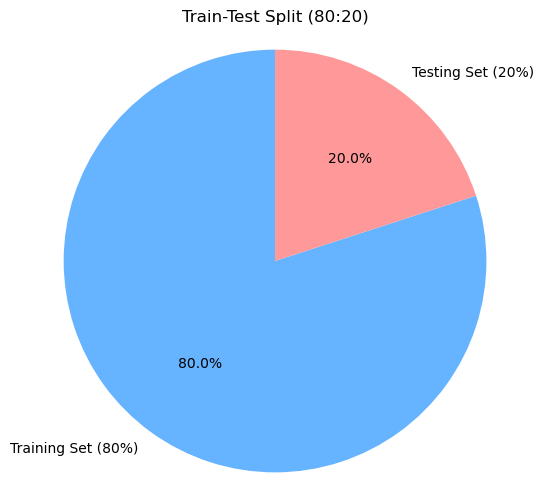

In [15]:

sizes = [80, 20]
labels = ['Training Set (80%)', 'Testing Set (20%)']
colors = ['#66b3ff', '#ff9999']

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Train-Test Split (80:20)')
plt.axis('equal')  # Supaya pie chartnya bulat
plt.show()

## Handle Imbalance target Class

Distribusi Kelas:
 loan_status
0    331041
1     41624
Name: count, dtype: int64


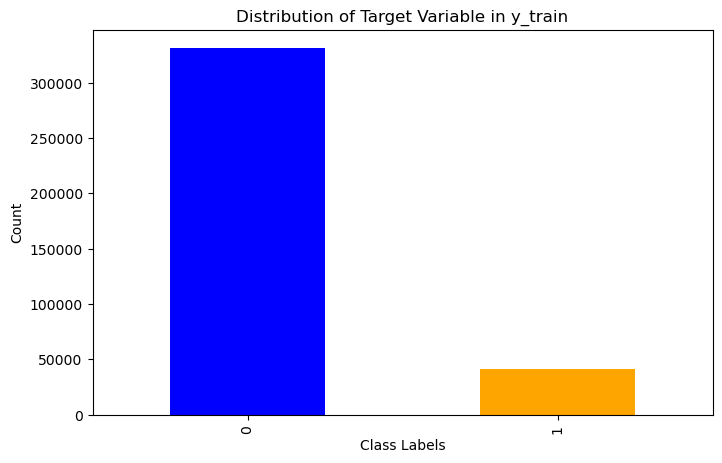

In [11]:
# Cek distribusi kelas
class_counts = y_train.value_counts()

# Tampilkan distribusi
print("Distribusi Kelas:\n", class_counts)

# Visualisasi
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Target Variable in y_train")
plt.show()

In [9]:
# Lakukan oversampling pada data latih
smote = SMOTE(sampling_strategy=1, random_state=42) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [10]:
X_train_e = X_train.copy()
y_train_e = y_train.copy()

Distribusi Kelas:
 loan_status
0    331041
1    331041
Name: count, dtype: int64


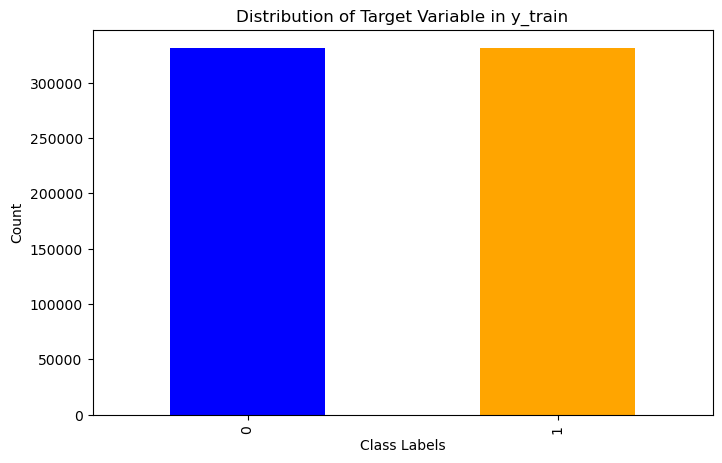

In [11]:
# Cek distribusi kelas
class_counts = y_train_smote.value_counts()

# Tampilkan distribusi
print("Distribusi Kelas:\n", class_counts)

# Visualisasi
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Target Variable in y_train")
plt.show()

## Scaling Data

- Scaling dilakukan pada train data kecuali pada fitur dengan type boolean

In [14]:
# Pisahkan fitur numerik dan boolean
bool_columns = X.select_dtypes(include=['bool']).columns
num_columns = X.columns.difference(bool_columns)

In [15]:

X_train = X_train_smote.copy()
y_train = y_train_smote.copy()

In [16]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_columns])
X_train[num_columns] = scaler.transform(X_train[num_columns])
X_train_e[num_columns] = scaler.transform(X_train_e[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

# Modelling

In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score
)

def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    """
    Evaluates a classification model and returns a DataFrame with key metrics for both train and test datasets.
    
    Parameters:
    - model: Trained classification model (e.g., LogisticRegression, RandomForestClassifier, etc.)
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - y_test: Test labels
    
    Returns:
    - metrics_df: A DataFrame containing evaluation metrics for both train and test sets.
    """
    # Predictions and probabilities
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Metrics for Train Set
    train_metrics = {
        "Accuracy": accuracy_score(y_train, y_pred_train),
        "Precision": precision_score(y_train, y_pred_train),
        "Recall": recall_score(y_train, y_pred_train),
        "F1-Score": f1_score(y_train, y_pred_train),
        "ROC-AUC": roc_auc_score(y_train, y_proba_train),
    }
    
    # Metrics for Test Set
    test_metrics = {
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test),
        "Recall": recall_score(y_test, y_pred_test),
        "F1-Score": f1_score(y_test, y_pred_test),
        "ROC-AUC": roc_auc_score(y_test, y_proba_test),
    }
    
    # Combine metrics into a DataFrame
    metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"])
    
    return metrics_df.T

## Model 1 : Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=-1)
logreg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

In [21]:
logreg_result = evaluate_metrics(logreg, X_train_e, y_train_e, X_test, y_test)
logreg_result

,Train,Test
Accuracy,0.801964,0.800627
Precision,0.196426,0.194874
Recall,0.250096,0.246660
F1-Score,0.220036,0.217730
ROC-AUC,0.623417,0.620489


## Model 2 : Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
dtree_result = evaluate_metrics(dtree, X_train_e, y_train_e, X_test, y_test)
dtree_result

,Train,Test
Accuracy,1.0,0.784334
Precision,1.0,0.151779
Recall,1.0,0.199905
F1-Score,1.0,0.172549
ROC-AUC,1.0,0.529155


## Model 3 : Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [27]:
rf_model_result = evaluate_metrics(rf_model, X_train_e, y_train_e, X_test, y_test)
rf_model_result

,Train,Test
Accuracy,0.999984,0.883800
Precision,1.000000,0.258380
Recall,0.999856,0.017653
F1-Score,0.999928,0.033048
ROC-AUC,1.000000,0.649656


## Model 4 : XGBoost

In [29]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_jobs=-1)
xgb_model.fit(X_train, y_train)

C:\Users\refdinal\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:14:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [30]:
xgb_model_result = evaluate_metrics(xgb_model, X_train_e, y_train_e, X_test, y_test)
xgb_model_result

,Train,Test
Accuracy,0.888900,0.886966
Precision,0.678514,0.333333
Recall,0.010090,0.004866
F1-Score,0.019885,0.009593
ROC-AUC,0.719950,0.678502


### Model Comparison

In [32]:
comparison_df_test = pd.DataFrame()
comparison_df_train = pd.DataFrame()

In [33]:
comparison_df_test['Logistic Regression'] = logreg_result['Test']
comparison_df_test['Decision Tree'] = dtree_result['Test']
comparison_df_test['Random Forest Classifier'] = rf_model_result['Test']
comparison_df_test['XGBoost'] = xgb_model_result['Test']
comparison_df_train['Logistic Regression'] = logreg_result['Train']
comparison_df_train['Decision Tree'] = dtree_result['Train']
comparison_df_train['Random Forest Classifier'] = rf_model_result['Train']
comparison_df_train['XGBoost'] = xgb_model_result['Train']

In [34]:
comparison_df_train

,Logistic Regression,Decision Tree,Random Forest Classifier,XGBoost
Accuracy,0.801964,1.0,0.999984,0.888900
Precision,0.196426,1.0,1.000000,0.678514
Recall,0.250096,1.0,0.999856,0.010090
F1-Score,0.220036,1.0,0.999928,0.019885
ROC-AUC,0.623417,1.0,1.000000,0.719950


In [35]:
comparison_df_test

,Logistic Regression,Decision Tree,Random Forest Classifier,XGBoost
Accuracy,0.800627,0.784334,0.883800,0.886966
Precision,0.194874,0.151779,0.258380,0.333333
Recall,0.246660,0.199905,0.017653,0.004866
F1-Score,0.217730,0.172549,0.033048,0.009593
ROC-AUC,0.620489,0.529155,0.649656,0.678502


## Tuning XGboost

In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]  # sesuaikan dengan rasio kelasmu
}


In [102]:
f1 = make_scorer(f1_score, average='binary')


In [67]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f1,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)  # Pastikan X_train dan y_train sudah siap


Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\refdinal\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:33:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 5, 10],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary),
             verbose=2)

In [69]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 1.0}
Best F1 Score: 0.916841549882979


In [71]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     82687
           1       0.34      0.01      0.01     10480

    accuracy                           0.89     93167
   macro avg       0.61      0.50      0.48     93167
weighted avg       0.83      0.89      0.84     93167



In [104]:
xgb_model = XGBClassifier(
    scale_pos_weight=8,
    max_depth=7,
    learning_rate=0.2,
    n_estimators=200,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\refdinal\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:28:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.93      0.62      0.75     82687
           1       0.17      0.63      0.27     10480

    accuracy                           0.62     93167
   macro avg       0.55      0.63      0.51     93167
weighted avg       0.84      0.62      0.69     93167



In [105]:
xgb_model_result = evaluate_metrics(xgb_model, X_train_e, y_train_e, X_test, y_test)
xgb_model_result

,Train,Test
Accuracy,0.656582,0.623525
Precision,0.214673,0.174523
Recall,0.780463,0.629198
F1-Score,0.336726,0.273253
ROC-AUC,0.787361,0.676531


## Tuning Logistic Regression

In [88]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],   # Regularization
    'C': [0.01, 0.1, 1, 10],                         # Regularization strength
    'solver': ['liblinear', 'saga'],                # Sesuai dengan penalty
    'class_weight': [None, 'balanced'],             # Untuk handling imbalance
    'max_iter': [100, 500]                          # Untuk memastikan konvergen
}


In [107]:
best_params = {
    'C': 0.01,
    'class_weight': None,
    'max_iter': 100,
    'penalty': 'l2',
    'solver': 'liblinear'
}


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.86      0.88     82687
           1       0.19      0.25      0.22     10480

    accuracy                           0.79     93167
   macro avg       0.55      0.56      0.55     93167
weighted avg       0.82      0.79      0.81     93167



In [92]:
from sklearn.metrics import classification_report

best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.86      0.88     82687
           1       0.19      0.25      0.22     10480

    accuracy                           0.79     93167
   macro avg       0.55      0.56      0.55     93167
weighted avg       0.82      0.79      0.81     93167



In [108]:
logreg_model_result = evaluate_metrics(best_logreg, X_train_e, y_train_e, X_test, y_test)
logreg_model_result

,Train,Test
Accuracy,0.796184,0.794198
Precision,0.193665,0.190208
Recall,0.260715,0.254676
F1-Score,0.222243,0.217771
ROC-AUC,0.621110,0.618207
